# WIKI-SHEAF

@ Alessio Borgi
@ Stefano Previti

### 0: IMPORTING LIBRARIES

In [29]:
!pip install requests wikipedia-api wptools networkx matplotlib

In [42]:
### LIBRARIES NECESSARY FOR STEP 1 ###
import json
import pprint
import wptools
import requests
import wikipediaapi
from urllib.parse import urlparse, unquote

### LIBRARIES NECESSARY FOR STEP 2 ###
import networkx as nx

### LIBRARIES NECESSARY FOR STEP 3 ###
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_networkx
from sentence_transformers import SentenceTransformer



### 1: GATHERING NECESSARY INFORMATION

#### 1.1: WIKIPEDIA INFORMATION EXTRACTION

In [43]:
def get_wikipedia_data(page_url):
    '''
    Function to extract data from an English Wikipedia page.
    It retrieves:
      - Page title
      - Summary
      - Categories
      - Infobox data
      - Internal links
      - External links
      - References and citations
      - Geographical coordinates
      - List of headings (titles and subtitles)
    '''

    # 1) Title extraction.
    parsed_url = urlparse(page_url)
    title = unquote(parsed_url.path.split("/")[-1])

    # 2) Wikipedia API object for English Wikipedia.
    page = wikipediaapi.Wikipedia(
        user_agent="WikiSheaf/1.0",
        language='en'
    ).page(title)

    if not page.exists():
        return None

    # 3) Extracted data Dictionary creation.
    data = {}

    # 4) Title, Summary and Categories Inclusion in the Dictionary.
    data['title'] = page.title
    data['summary'] = page.summary
    data['categories'] = list(page.categories.keys())

    # 5) Infobox, internal & external links, references & citations, geo info
    #    and headings additional information.
    try:

        # Fetch parsed data from Wikipedia.
        wp_page = wptools.page(title, lang="en")
        wp_page.get_parse()
        extra = wp_page.data

        # Extract all the "additional" info.
        data["infobox"] = extra.get("infobox", None)
        data["internal_links"] = extra.get("links", None)
        data["external_links"] = extra.get("externallinks", None)
        data["references"] = extra.get("references", None)
        data["geographical_coordinates"] = extra.get("coordinates", None)
        data["headings"] = extra.get("sections", None)

    except Exception as e:
        print(f"Error fetching extra data from wptools for page '{title}':", e)
        data["infobox"] = None
        data["internal_links"] = None
        data["external_links"] = None
        data["references"] = None
        data["geographical_coordinates"] = None
        data["headings"] = None

    return data


##### 1.1.1: WIKIPEDIA INFORMATION EXTRACTION - EXAMPLE USAGE

In [44]:
print("STARTING TO EXTRACT FROM WIKIPEDIA...\n")
wikipedia_url = "https://en.wikipedia.org/wiki/Pizza"
wikipedia_data = get_wikipedia_data(wikipedia_url)

STARTING TO EXTRACT FROM WIKIPEDIA...



en.wikipedia.org (parse) Pizza
en.wikipedia.org (imageinfo) File:Pizza-3007395.jpg
Pizza (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Pizza-300...
  infobox: <dict(12)> name, image, image_size, caption, country, r...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 24768
  parsetree: <str(77266)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Pizza
  wikibase: Q177
  wikidata_url: https://www.wikidata.org/wiki/Q177
  wikitext: <str(61267)> {{Short description|Italian dish with a f...
}


In [45]:
print("PRINTING DATA EXTRACTED FROM WIKIPEDIA...\n")
pprint.pprint(wikipedia_data)

PRINTING DATA EXTRACTED FROM WIKIPEDIA...

{'categories': ['Category:All Wikipedia articles written in American English',
                'Category:All articles with vague or ambiguous time',
                'Category:Articles with short description',
                'Category:CS1 Greek-language sources (el)',
                'Category:CS1 Italian-language sources (it)',
                'Category:CS1 Spanish-language sources (es)',
                'Category:CS1 Swedish-language sources (sv)',
                'Category:CS1 uses Greek-language script (el)',
                'Category:Cheese dishes',
                'Category:Commons category link is on Wikidata',
                'Category:Convenience foods',
                'Category:Flatbread dishes',
                'Category:Food combinations',
                'Category:Italian cuisine',
                'Category:Italian inventions',
                'Category:Mediterranean cuisine',
                'Category:National dishes',
         

#### 1.2: WIKIDATA INFORMATION EXTRACTION

In [46]:
def parse_wikidata_id(wikidata_url):
    '''
    Helper function to extract the Wikidata ID from a given Wikidata URL.
    '''
    return unquote(urlparse(wikidata_url).path.split("/")[-1])

def get_wikidata_data(wikidata_url):
    '''
    Function to extract the complete information from a Wikidata record.
    It retrieves:
          - Label
          - Description
          - Aliases (alternative names)
          - Instance of (P31)
          - Subclass of (P279)
          - Inception (P571)
          - Image (P18)
          - Country (P17)
          - Official website (P856)
          - Creator/Author (P170)
          - Location (P276)
          - Genre/Style (P136)
      It then extracts the English Wikipedia URL from the sitelinks and calls
      get_wikipedia_data() to fetch Wikipedia page info.
    '''
    # 1) Get the Wikidata ID.
    wikidata_id = parse_wikidata_id(wikidata_url)
    URL = f"https://www.wikidata.org/wiki/Special:EntityData/{wikidata_id}.json"

    # 2) Retrieve all the Wikidata.
    try:
        # 2.1) Fetch data from Wikidata API.
        response = requests.get(URL)
        data = response.json()
        entity = data.get("entities", {}).get(wikidata_id, {})
        wikidata_info = {}
        wikidata_info["id"] = wikidata_id

        # 2.2) Retrieve basic labels, descriptions.
        wikidata_info["label"] = entity.get("labels", {}).get("en", {}).get("value", None)
        wikidata_info["description"] = entity.get("descriptions", {}).get("en", {}).get("value", None)

        # 2.3) Retrieve aliases (alternative names) in English.
        if "aliases" in entity and "en" in entity["aliases"]:
            wikidata_info["aliases"] = [alias.get("value") for alias in entity["aliases"]["en"]]
        else:
            wikidata_info["aliases"] = None

        # 2.4) Extract claims (properties (each one may include multiple values)).
        claims = entity.get("claims", {})

        # 2.4.1) "Instance of" (P31).
        if "P31" in claims:
            wikidata_info["instance_of"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P31"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["instance_of"] = None

        # 2.4.2) "Subclass of" (P279).
        if "P279" in claims:
            wikidata_info["subclass_of"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P279"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["subclass_of"] = None

        # 2.4.3) "Inception" (P571).
        if "P571" in claims:
            wikidata_info["inception"] = [
                claim["mainsnak"]["datavalue"]["value"]["time"]
                for claim in claims["P571"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["inception"] = None

        # 2.4.4) "Image" (P18).
        if "P18" in claims:
            wikidata_info["image"] = [
                claim["mainsnak"]["datavalue"]["value"]
                for claim in claims["P18"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["image"] = None

        # 2.4.5) "Country" (P17).
        if "P17" in claims:
            wikidata_info["country"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P17"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["country"] = None

        # 2.4.6) "Official website" (P856).
        if "P856" in claims:
            wikidata_info["official_website"] = [
                claim["mainsnak"]["datavalue"]["value"]
                for claim in claims["P856"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["official_website"] = None

        # 2.4.7) "Creator/Author" (P170). (for cultural items like art or literature).
        if "P170" in claims:
            wikidata_info["creator"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P170"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["creator"] = None

        # 2.4.8) "Location" (P276).
        if "P276" in claims:
            wikidata_info["location"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P276"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["location"] = None

        # 2.4.9) "Genre/Style" (P136).
        if "P136" in claims:
            wikidata_info["genre"] = [
                claim["mainsnak"]["datavalue"]["value"]["id"]
                for claim in claims["P136"]
                if "mainsnak" in claim and "datavalue" in claim["mainsnak"]
            ]
        else:
            wikidata_info["genre"] = None

        # 2.5) Extract English Wikipedia URL and call the get_wikipedia_data() function.
        if "sitelinks" in entity and "enwiki" in entity["sitelinks"]:
            wikipedia_url = entity["sitelinks"]["enwiki"].get("url", None)
        else:
            wikipedia_url = None
        wikidata_info["wikipedia_url"] = wikipedia_url

        if wikipedia_url:
            wiki_data = get_wikipedia_data(wikipedia_url)
        else:
            wiki_data = None
        wikidata_info["wikipedia_data"] = wiki_data

        return wikidata_info

    except Exception as e:
        print(f"Error fetching Wikidata data for {wikidata_url}: {e}")
        return None

##### 1.2.1: WIKIDATA INFORMATION EXTRACTION - EXAMPLE USAGE

In [47]:
wikidata_url = "https://www.wikidata.org/wiki/Q177" # (Pizza)
wikidata_record = get_wikidata_data(wikidata_url)

en.wikipedia.org (parse) Pizza
en.wikipedia.org (imageinfo) File:Pizza-3007395.jpg
Pizza (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Pizza-300...
  infobox: <dict(12)> name, image, image_size, caption, country, r...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 24768
  parsetree: <str(77266)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Pizza
  wikibase: Q177
  wikidata_url: https://www.wikidata.org/wiki/Q177
  wikitext: <str(61267)> {{Short description|Italian dish with a f...
}


In [48]:
pprint.pprint(wikidata_record)

{'aliases': ['pie', 'pizza pie'],
 'country': None,
 'creator': None,
 'description': 'Italian universal popular dish with a flat dough-based base '
                'and toppings',
 'genre': None,
 'id': 'Q177',
 'image': ['Eq it-na pizza-margherita sep2005 sml.jpg', 'Pizza-3007395.jpg'],
 'inception': None,
 'instance_of': ['Q19861951'],
 'label': 'pizza',
 'location': None,
 'official_website': None,
 'subclass_of': ['Q13030962', 'Q1408229', 'Q749316', 'Q2251745', 'Q26996677'],
 'wikipedia_data': {'categories': ['Category:All Wikipedia articles written in '
                                   'American English',
                                   'Category:All articles with vague or '
                                   'ambiguous time',
                                   'Category:Articles with short description',
                                   'Category:CS1 Greek-language sources (el)',
                                   'Category:CS1 Italian-language sources (it)',
             

### 2: BUILDING THE GRAPHS

en.wikipedia.org (parse) Pizza
en.wikipedia.org (imageinfo) File:Pizza-3007395.jpg
Pizza (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Pizza-300...
  infobox: <dict(12)> name, image, image_size, caption, country, r...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 24768
  parsetree: <str(77266)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Pizza
  wikibase: Q177
  wikidata_url: https://www.wikidata.org/wiki/Q177
  wikitext: <str(61267)> {{Short description|Italian dish with a f...
}


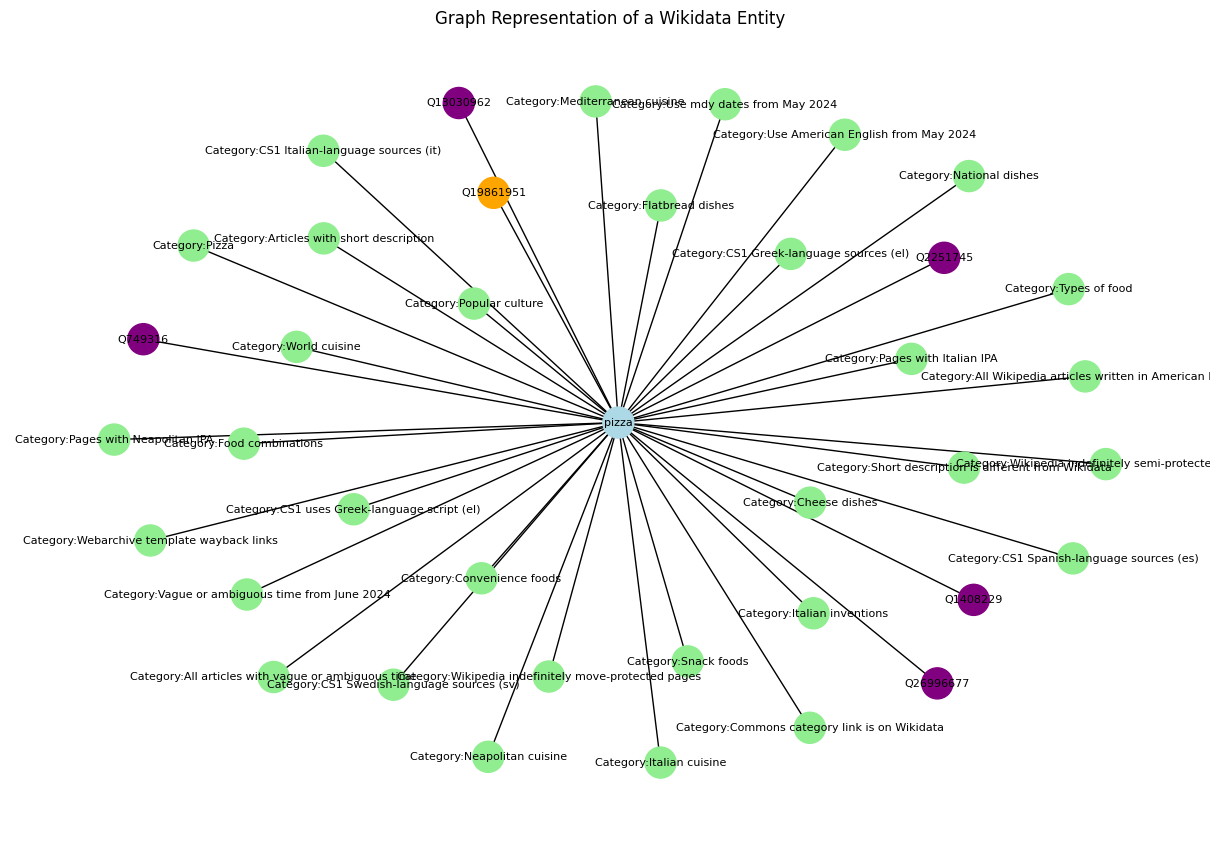

In [49]:
# ========================
# Graph Construction and Visualization
# ========================

def build_graph(wikidata_info):
    """
    Build a graph from the wikidata_info dictionary.

    The graph will include:
      - A main node representing the item (using its Wikidata ID and label).
      - Nodes for Wikipedia categories (from the Wikipedia data).
      - Nodes for other attributes: instance_of, subclass_of, creator, location, genre.
    Each attribute node is connected to the main item node.
    """


    G = nx.Graph()  # Using an undirected graph for visualization

    main_node = wikidata_info["id"]
    main_label = wikidata_info.get("label", main_node)
    G.add_node(main_node, label=main_label, type="item")

    # Add Wikipedia categories from the enriched Wikipedia data.
    wikipedia_data = wikidata_info.get("wikipedia_data", {})
    categories = wikipedia_data.get("categories", [])
    for cat in categories:
        cat_node = f"cat:{cat}"
        G.add_node(cat_node, label=cat, type="category")
        G.add_edge(main_node, cat_node)

    # Add 'instance_of' nodes.
    instance_of = wikidata_info.get("instance_of", [])
    if instance_of:
        for inst in instance_of:
            node = f"inst:{inst}"
            G.add_node(node, label=inst, type="instance_of")
            G.add_edge(main_node, node)

    # Add 'subclass_of' nodes.
    subclass_of = wikidata_info.get("subclass_of", [])
    if subclass_of:
        for sub in subclass_of:
            node = f"subclass:{sub}"
            G.add_node(node, label=sub, type="subclass_of")
            G.add_edge(main_node, node)

    # Add 'creator' nodes.
    creator = wikidata_info.get("creator", [])
    if creator:
        for cre in creator:
            node = f"creator:{cre}"
            G.add_node(node, label=cre, type="creator")
            G.add_edge(main_node, node)

    # Add 'location' nodes.
    location = wikidata_info.get("location", [])
    if location:
        for loc in location:
            node = f"loc:{loc}"
            G.add_node(node, label=loc, type="location")
            G.add_edge(main_node, node)

    # Add 'genre' nodes.
    genre = wikidata_info.get("genre", [])
    if genre:
        for gen in genre:
            node = f"genre:{gen}"
            G.add_node(node, label=gen, type="genre")
            G.add_edge(main_node, node)

    return G

def visualize_graph(G):
    """
    Visualize the graph using matplotlib.
    Different node types are colored differently.
    """
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(G, seed=42)  # reproducible layout

    # Retrieve node labels and types.
    node_labels = nx.get_node_attributes(G, 'label')
    node_types = nx.get_node_attributes(G, 'type')

    # Set colors based on node type.
    color_map = []
    for node in G.nodes():
        ntype = node_types.get(node, "item")
        if ntype == "item":
            color_map.append("lightblue")
        elif ntype == "category":
            color_map.append("lightgreen")
        elif ntype == "instance_of":
            color_map.append("orange")
        elif ntype == "subclass_of":
            color_map.append("purple")
        elif ntype == "creator":
            color_map.append("pink")
        elif ntype == "location":
            color_map.append("yellow")
        elif ntype == "genre":
            color_map.append("cyan")
        else:
            color_map.append("gray")

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=color_map, node_size=500, font_size=8)
    plt.title("Graph Representation of a Wikidata Entity")
    plt.show()

# ========================
# Example Usage
# ========================

if __name__ == "__main__":
    # Example dataset row: a Wikidata URL for an entity (e.g., Pizza).
    wikidata_url = "https://www.wikidata.org/wiki/Q177"

    # Gather enriched Wikidata and Wikipedia info.
    wikidata_info = get_wikidata_data(wikidata_url)

    # Build a graph for this entity.
    G = build_graph(wikidata_info)

    # Visualize the graph.
    visualize_graph(G)

en.wikipedia.org (parse) Pizza
en.wikipedia.org (imageinfo) File:Pizza-3007395.jpg
Pizza (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Pizza-300...
  infobox: <dict(12)> name, image, image_size, caption, country, r...
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 24768
  parsetree: <str(77266)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Pizza
  wikibase: Q177
  wikidata_url: https://www.wikidata.org/wiki/Q177
  wikitext: <str(61267)> {{Short description|Italian dish with a f...
}


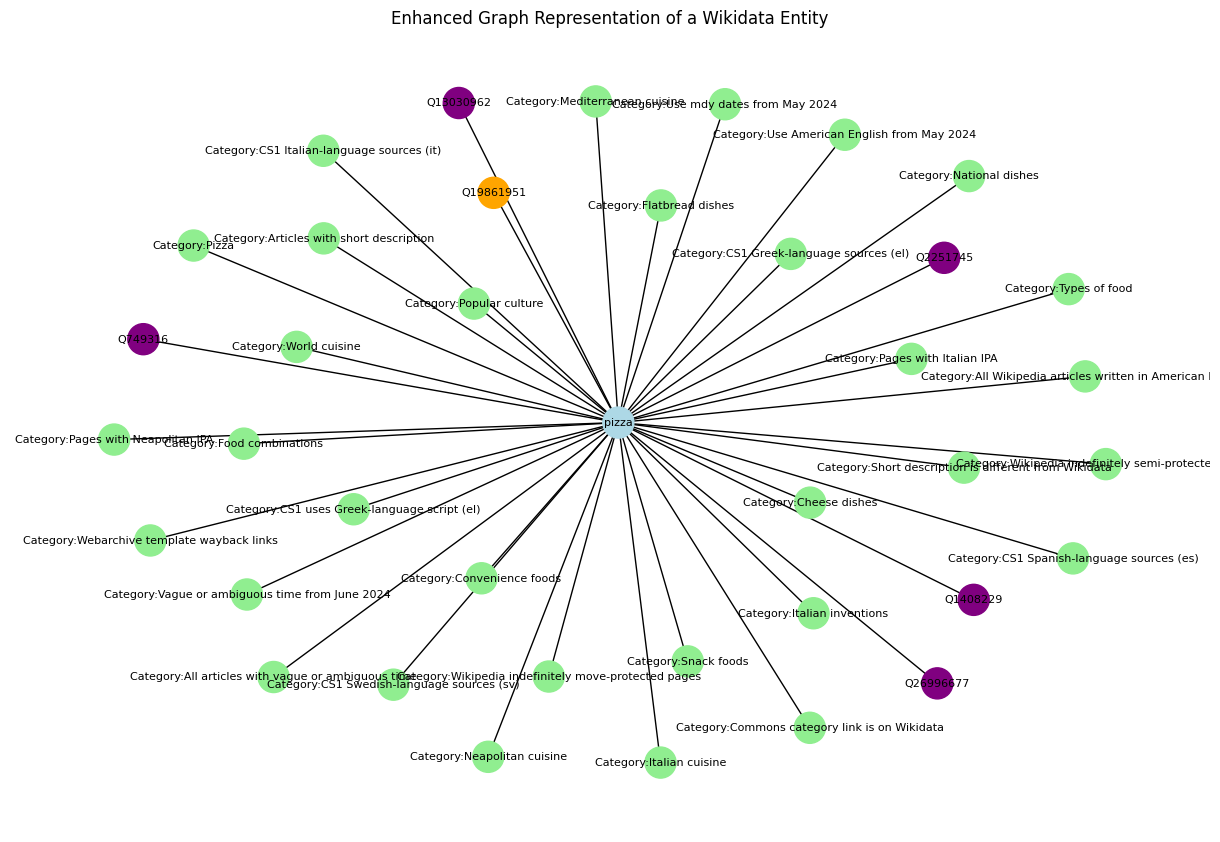

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

def build_enhanced_graph(wikidata_info):
    """
    Build an enhanced heterogeneous graph from the wikidata_info dictionary.

    Nodes:
      - Main item node.
      - Attribute nodes for categories, instance_of, subclass_of, creator, location, and genre.

    Edges:
      - Each edge includes attributes 'rel_type' and 'weight' (default 1.0).
    """
    G = nx.Graph()  # For simplicity, an undirected graph is used here.

    # Add the main item node.
    main_node = wikidata_info["id"]
    main_label = wikidata_info.get("label", main_node)
    G.add_node(main_node, label=main_label, type="item")

    # Function to add attribute nodes with a given relation type.
    def add_attribute_nodes(attribute_list, prefix, rel_type):
        if attribute_list:
            for attr in attribute_list:
                node = f"{prefix}:{attr}"
                G.add_node(node, label=attr, type=rel_type)
                G.add_edge(main_node, node, rel_type=rel_type, weight=1.0)

    # Add Wikipedia categories as nodes.
    wikipedia_data = wikidata_info.get("wikipedia_data", {})
    categories = wikipedia_data.get("categories", [])
    add_attribute_nodes(categories, "cat", "has_category")

    # Add instance_of nodes.
    add_attribute_nodes(wikidata_info.get("instance_of", []), "inst", "instance_of")

    # Add subclass_of nodes.
    add_attribute_nodes(wikidata_info.get("subclass_of", []), "subclass", "subclass_of")

    # Add creator nodes.
    add_attribute_nodes(wikidata_info.get("creator", []), "creator", "creator")

    # Add location nodes.
    add_attribute_nodes(wikidata_info.get("location", []), "loc", "location")

    # Add genre nodes.
    add_attribute_nodes(wikidata_info.get("genre", []), "genre", "genre")

    return G

def visualize_enhanced_graph(G):
    """
    Visualize the enhanced graph using matplotlib.
    Nodes are colored based on their type.
    """
    pos = nx.spring_layout(G, seed=42)
    node_labels = nx.get_node_attributes(G, 'label')
    node_types = nx.get_node_attributes(G, 'type')

    # Color mapping for different node types.
    color_map = []
    for node in G.nodes():
        ntype = node_types.get(node, "item")
        if ntype == "item":
            color_map.append("lightblue")
        elif ntype == "has_category":
            color_map.append("lightgreen")
        elif ntype == "instance_of":
            color_map.append("orange")
        elif ntype == "subclass_of":
            color_map.append("purple")
        elif ntype == "creator":
            color_map.append("pink")
        elif ntype == "location":
            color_map.append("yellow")
        elif ntype == "genre":
            color_map.append("cyan")
        else:
            color_map.append("gray")

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=color_map, node_size=500, font_size=8)
    plt.title("Enhanced Graph Representation of a Wikidata Entity")
    plt.show()

# ========================
# Example Usage
# ========================
if __name__ == "__main__":
    # Example Wikidata URL for an entity (e.g., Pizza).
    wikidata_url = "https://www.wikidata.org/wiki/Q177"

    # Assume get_wikidata_data() is already defined and imported.
    wikidata_info = get_wikidata_data(wikidata_url)

    # Build the enhanced graph.
    G = build_enhanced_graph(wikidata_info)

    # Visualize the graph.
    visualize_enhanced_graph(G)


In [51]:
!pip install torch torch-geometric sentence-transformers networkx matplotlib


#### 3.1: BUILDING GRAPH (ENHANCED)

In this step we make use of the **Sentence Transformer** (with the all-mpnet-base-v2 model) in order to provide a **Contextual Embedding**. This is done because it provides high-quality contextual embeddings that capture fine semantic nuances in text and serve feature vectors for each atttribute node.


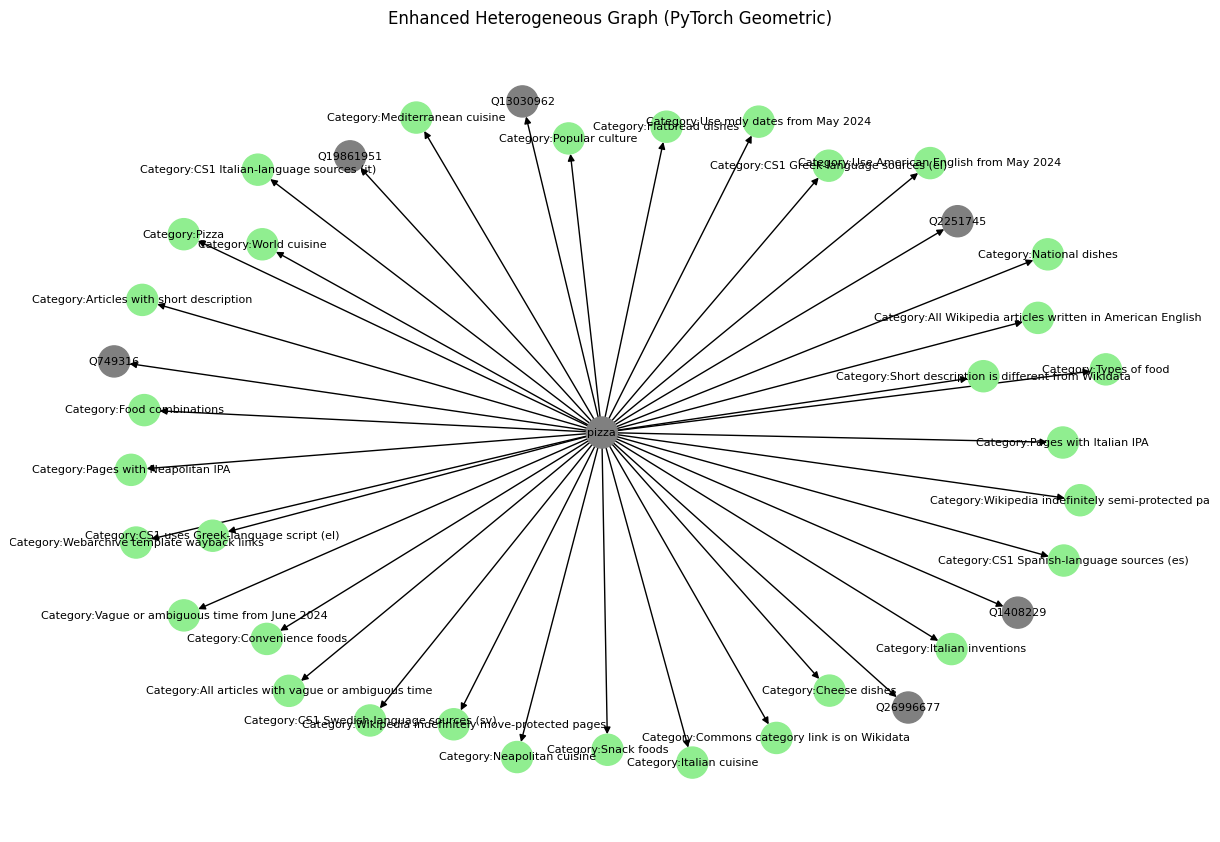

In [52]:
def build_enhanced_hetero_graph(wikidata_info):
    """
    Build an enhanced Heterogeneous Graph from the gathered wikidata information.

    Node Types:
      - "item": the main entity.
      - "category", "instance", "subclass", "creator", "location", "genre": attribute nodes.

    For each node, we compute a contextual embedding from its label.
    For edges, we compute semantic similarity (cosine similarity) between the main item's embedding
    and the attribute node embedding as the edge weight.

    Returns:
        data: A HeteroData object representing the graph.
    """
    data = HeteroData()

    # Add the main item node.
    main_id = wikidata_info["id"]
    main_label = wikidata_info.get("label", main_id)
    # Compute embedding for the main label.
    # 1) Setting up the SentenceTransformer model for Contextual Embeddings.
    # Here we use the all-mpnet-base-v2 model for higher-quality embeddings.
    model = SentenceTransformer('all-mpnet-base-v2')
    main_embedding = model.encode(main_label)
    main_embedding = torch.tensor(main_embedding, dtype=torch.float).unsqueeze(0)  # shape [1, emb_dim]
    data["item"].x = main_embedding
    data["item"].label = [main_label]

    # Helper: add attribute nodes and edges.
    def add_attr_nodes(attr_list, node_type, edge_type):
        # If attr_list is None or empty, create an empty node set.
        if not attr_list:
            data[node_type].x = torch.empty((0, main_embedding.size(1)), dtype=torch.float)
            data[node_type].label = []
            return

        # Compute embeddings for each attribute.
        embeddings = model.encode(attr_list)
        embeddings = torch.tensor(embeddings, dtype=torch.float)
        data[node_type].x = embeddings
        data[node_type].label = attr_list

        num_nodes = embeddings.size(0)
        # Create edge index: from main item node (index 0) to each attribute node (indices 0...num_nodes-1)
        edge_index = torch.stack([torch.zeros(num_nodes, dtype=torch.long),
                                  torch.arange(num_nodes, dtype=torch.long)], dim=0)
        # Compute cosine similarity between main_embedding and each attribute embedding.
        sim_scores = F.cosine_similarity(main_embedding.squeeze(0).unsqueeze(0).expand(num_nodes, -1), embeddings, dim=1)
        # Reshape similarity scores as edge attributes.
        edge_attr = sim_scores.unsqueeze(1)  # shape [num_nodes, 1]
        data[("item", edge_type, node_type)].edge_index = edge_index
        data[("item", edge_type, node_type)].edge_attr = edge_attr

    # For categories, use wikipedia_data categories.
    categories = wikidata_info.get("wikipedia_data", {}).get("categories", [])
    add_attr_nodes(categories, "category", "has_category")

    # For instance_of:
    add_attr_nodes(wikidata_info.get("instance_of", []), "instance", "instance_of")

    # For subclass_of:
    add_attr_nodes(wikidata_info.get("subclass_of", []), "subclass", "subclass_of")

    # For creator:
    add_attr_nodes(wikidata_info.get("creator", []), "creator", "creator")

    # For location:
    add_attr_nodes(wikidata_info.get("location", []), "location", "location")

    # For genre:
    add_attr_nodes(wikidata_info.get("genre", []), "genre", "genre")

    return data

# ========================
# Visualization: Convert to a NetworkX graph for visualization.
# ========================
def visualize_hetero_graph(data):
    """
    Visualize the heterogeneous graph by converting it to a homogeneous NetworkX graph.
    For simplicity, we assign colors based on the node type (if known).
    """
    G = to_networkx(data, node_attrs=['label'])
    pos = nx.spring_layout(G, seed=42)

    # Here, we define a simple color mapping based on node label contents.
    # The main item node (from "item") gets a specific color.
    color_map = []
    for node in G.nodes():
        label = G.nodes[node].get('label', '')
        if isinstance(label, list) and len(label) > 0:
            label = label[0]
        if node in data["item"].label:
            color_map.append("lightblue")
        elif any(prefix in label for prefix in ["Category:", "cat:"]):
            color_map.append("lightgreen")
        else:
            color_map.append("gray")

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
            node_color=color_map, node_size=500, font_size=8)
    plt.title("Enhanced Heterogeneous Graph (PyTorch Geometric)")
    plt.show()

# ========================
# Example Usage
# ========================
if __name__ == "__main__":
    # Assume get_wikidata_data() is defined and returns enriched data (here we use enriched_data as example).
    # wikidata_url = "https://www.wikidata.org/wiki/Q177"
    # wikidata_info = get_wikidata_data(wikidata_url)
    wikidata_info = wikidata_record  # using our sample data

    # Build the enhanced heterogeneous graph.
    hetero_graph = build_enhanced_hetero_graph(wikidata_info)

    # Visualize the graph.
    visualize_hetero_graph(hetero_graph)


### 3: HETEROPHILY INDEX

### 4: SHEAF NEURAL NETWORK